# Import Packages

In [1]:
import pandas as pd
from sodapy import Socrata
import os
import re
import requests
import json
import folium
from folium import plugins
from folium.plugins import HeatMap
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

pd.set_option("display.max_columns", None)

# Functions

In [17]:
def human_address(dataframe):
    """extract and convert the address in permit location column to 123 jake way, silver sprind, md 20904 format
    and create list to make new a column"""
    output = [] 
    for i,row in dataframe.iterrows():
        human_address = row.location.get('human_address')
        pattern = re.compile('[",{,},a-z]')
        clean_address = re.sub(pattern, '', human_address)
        address_lst = clean_address.split(':')
        address = f"{address_lst[1].strip()}, {address_lst[2].strip()}, {address_lst[3].strip()} {address_lst[4].strip()}"
        output.append(address.lower())
    return output


def lat_long_extraction(dataframe):
    """Extract latitude and longitude from location column and create two list to make new columns"""
    latitude_lst = []
    longitude_lst = []
    for i , row in dataframe.iterrows():
        latitude = row.location.get('latitude')
        longitude = row.location.get('longitude')
        latitude_lst.append(latitude)
        longitude_lst.append(longitude)
    return latitude_lst,longitude_lst

def google_lat_long(dataframe):
    """google API call to find latitude and longitude from the address and create two list to make new columns """
    latitude_lst = []
    longitude_lst = []
    for address in human_address(dataframe):
       
        #example from google to use api to get latitude and longitude
        api_key = "API KEY"
        api_response = requests.get('https://maps.googleapis.com/maps/api/geocode/json?address={0}&key={1}'.format(
            address, api_key))
        api_response_dict = api_response.json()

        if api_response_dict['status'] == 'OK':
            latitude = api_response_dict['results'][0]['geometry']['location']['lat']
            longitude = api_response_dict['results'][0]['geometry']['location']['lng']
            latitude_lst.append(latitude)
            longitude_lst.append(longitude)
        else:
            latitude_lst.append(0)
            longitude_lst.append(0)
    return latitude_lst,longitude_lst


def zillow_api(home_type):
    url = "https://zillow-com1.p.rapidapi.com/propertyExtendedSearch"

    querystring = {"location":"montgomery county, md","page":"1","status_type":"ForSale","home_type":home_type,
                   "sort":"Newest","maxPrice":"587000"}

    headers = {
        "X-RapidAPI-Host": "zillow-com1.p.rapidapi.com",
        "X-RapidAPI-Key": "API KEY"}

    #API Call 
    response = requests.request("GET", url, headers=headers, params=querystring)

    #convert response to dictionary
    result = json.loads(response.text)

    #convert dictionary to dataframe
    zillow_df = pd.DataFrame.from_dict(result.get('props')) 

    if result.get('totalPages', 0) > 1:
        count = 2
        for x in range(result.get('totalPages')-1):
            if x == 0:
                querystring['page'] = x + count 
                response = requests.request("GET", url, headers=headers, params=querystring)
                result = json.loads(response.text)
                zillow_temp_df = pd.DataFrame.from_dict(result.get('props')) 
                full_zillow_df = pd.concat([zillow_df, zillow_temp_df])
            else:
                querystring['page'] = x + count 
                response = requests.request("GET", url, headers=headers, params=querystring)
                result = json.loads(response.text)
                zillow_temp_df = pd.DataFrame.from_dict(result.get('props')) 
                full_zillow_df = pd.concat([full_zillow_df, zillow_temp_df]) 
        return full_zillow_df
    else:
        return zillow_df


# Data

## Upload Residential Permits from Scorate API

In [3]:
#authenticate client
client = Socrata('data.montgomerycountymd.gov',"MyAppToken","userame='user@example.com'","password='AFakePassword'")

#API Call for all residential permits
Res_permits = client.get_all("m88u-pqki")

#convert response to dataframe
Res_permits_df = pd.DataFrame.from_records(Res_permits)

## Clean Residential Permits Data

In [4]:
#Remove rows that are missing location information
Res_permits_df.dropna(subset=['location'], inplace = True)

#Remove columns
Res_permits_df.drop(':@computed_region_vu5j_pcmz',axis='columns', inplace = True)
Res_permits_df.drop(':@computed_region_tx5f_5em3',axis='columns', inplace = True)
Res_permits_df.drop(':@computed_region_kbsp_ykn9',axis='columns', inplace = True)
Res_permits_df.drop(':@computed_region_rbt8_3x7n',axis='columns', inplace = True)
Res_permits_df.drop(':@computed_region_d7bw_bq6x',axis='columns', inplace = True)
Res_permits_df.drop(':@computed_region_a9cs_3ed7',axis='columns', inplace = True)

#Extract address from location column
Res_permits_df['address'] = human_address(Res_permits_df)

#Extract latitude and longitude from location column
extracted_lat, extracted_long = lat_long_extraction(Res_permits_df)
Res_permits_df['latitude'] = extracted_lat
Res_permits_df['longitude'] = extracted_long

#convert declared valuation to float
Res_permits_df['declaredvaluation'] = Res_permits_df['declaredvaluation'].astype(float)

#split residential dataframe into a data frame with or without latitude and longitude
missing_location = Res_permits_df.loc[Res_permits_df.longitude.isnull()]
has_locaton = Res_permits_df.loc[Res_permits_df.longitude.notnull()]

#utilize google api to find latitude and longitude for table misssing the data and assign to columns
google_lat, google_long = google_lat_long(missing_location)
missing_location['latitude'] = google_lat
missing_location['longitude'] = google_long

#Join the two dataframes 
Res_permits_df = pd.concat([missing_location, has_locaton])

#remove rows that google wasn't able to get latitude and longitude for a location
Res_permits_df = Res_permits_df.loc[Res_permits_df.latitude != 0]

#drop location column
Res_permits_df.drop("location", axis='columns', inplace = True)

#drop duplicate rows
Res_permits_df.drop_duplicates(inplace=True)

#Create list to filter the residential dataframe for the desired property types
prop_type = ['DUPLEX', 'MULTI-FAMILY DWELLING', 'RETAINING WALL' 'SENIOR SINGLE FAMILY DWELLING',
                'SENIOR TOWNHOUSE', 'SENIOR VILLAS', 'SINGLE FAMILY DWELLING', 'TOWNHOUSE', 'MODULAR']

#Filter dataframe for desired property types
filtered_Res_permits_df = Res_permits_df.loc[Res_permits_df.usecode.isin(prop_type)]

#Change dates from string to datetime
filtered_Res_permits_df['addeddate'] = pd.to_datetime(filtered_Res_permits_df['addeddate'])
filtered_Res_permits_df['issueddate'] = pd.to_datetime(filtered_Res_permits_df['issueddate'])
filtered_Res_permits_df['finaleddate'] = pd.to_datetime(filtered_Res_permits_df['finaleddate'])

#save copy of dataframe as CSV
filtered_Res_permits_df.to_csv("final_residential_data.csv",index=False)

C:\Users\mivul\AppData\Local\Temp/ipykernel_39912/3440374846.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_location['latitude'] = google_lat
C:\Users\mivul\AppData\Local\Temp/ipykernel_39912/3440374846.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_location['longitude'] = google_long
C:\Users\mivul\AppData\Local\Temp/ipykernel_39912/3440374846.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

## Upload Commercial Permits from Scorate API

In [18]:
#authenticate client:
client = Socrata('data.montgomerycountymd.gov',"MyAppToken","userame='user@example.com'","password='AFakePassword'")

#Api Call for all commercial permits
Comm_permits = client.get_all("i26v-w6bd")

#convert response to dataframe
Comm_permits_df = pd.DataFrame.from_records(Comm_permits)

## Clean Commercial Permits Data

In [19]:
#Remove rows that are missing location information
Comm_permits_df.dropna(subset=['location'], inplace = True)

#Remove columns
Comm_permits_df.drop(':@computed_region_a9cs_3ed7',axis='columns', inplace = True)
Comm_permits_df.drop(':@computed_region_vu5j_pcmz',axis='columns', inplace = True)
Comm_permits_df.drop(':@computed_region_tx5f_5em3',axis='columns', inplace = True)
Comm_permits_df.drop(':@computed_region_kbsp_ykn9',axis='columns', inplace = True)
Comm_permits_df.drop(':@computed_region_d7bw_bq6x',axis='columns', inplace = True)
Comm_permits_df.drop(':@computed_region_rbt8_3x7n',axis='columns', inplace = True)
    
#extract latitude and longitide from location and create a new column for the values
extracted_lat, extracted_long = lat_long_extraction(Comm_permits_df)
Comm_permits_df['latitude'] = extracted_lat
Comm_permits_df['longitude'] = extracted_long
    

#convert dates from string to datetime
Comm_permits_df['addeddate'] = pd.to_datetime(Comm_permits_df['addeddate'])
Comm_permits_df['issueddate'] = pd.to_datetime(Comm_permits_df['issueddate'])
Comm_permits_df['finaleddate'] = pd.to_datetime(Comm_permits_df['finaleddate'])

#convert declared valuation to float
Comm_permits_df['declaredvaluation'] = Comm_permits_df['declaredvaluation'].astype(float)
   

#split residential dataframe into a data frame with or without latitude and longitude
missing_location = Comm_permits_df.loc[Comm_permits_df.longitude.isnull()]
has_locaton = Comm_permits_df.loc[Comm_permits_df.longitude.notnull()]

#utilize google api to find latitude and longitude for table misssing the data and assign to columns
google_lat, google_long = google_lat_long(missing_location)
missing_location['latitude'] = google_lat
missing_location['longitude'] = google_long

#Join the two dataframes 
Comm_permits_df = pd.concat([missing_location, has_locaton])

#remove rows that google wasn't able to get latitude and longitude for a location
Comm_permits_df = Comm_permits_df.loc[Comm_permits_df.latitude != 0]

#drop location column
Comm_permits_df.drop("location", axis='columns', inplace = True)

#drop duplicate rows
Comm_permits_df.drop_duplicates(inplace=True)

#Create list to filter the commercial dataframe for the desired usecode
usecode_lst = ['SINGLE FAMILY DWELLING', 'SENIOR VILLAS',
 'RESIDENTIAL, MULTIPLE FAMILY','MULTI-FAMILY DWELLING',
 'MULTI-FAMILY SENIOR CITIZEN BL',
 'MULTIFAMILY DWELLING HIGH RISE',
 'MULTIFAMILY DWELLING LOW RISE']

#Filter dataframe for desired property types
filtered_comm_permits_df = Comm_permits_df.loc[Comm_permits_df.usecode.isin(usecode_lst)]

#save copy of dataframe as CSV
filtered_comm_permits_df.to_csv("final_commercial_data.csv",index=False)

C:\Users\mivul\AppData\Local\Temp/ipykernel_39912/2622447264.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_location['latitude'] = google_lat
C:\Users\mivul\AppData\Local\Temp/ipykernel_39912/2622447264.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_location['longitude'] = google_long


## Upload SDAT Data from Scorate API

In [61]:
#create a list of desired fields
fields = ['premise_address_number_mdp_field_premsnum_sdat_field_20','premise_address_name_mdp_field_premsnam_sdat_field_23',
          'premise_address_type_mdp_field_premstyp_sdat_field_24','premise_address_city_mdp_field_premcity_sdat_field_25',
          'premise_address_zip_code_mdp_field_premzip_sdat_field_26',
          'sales_segment_1_transfer_date_yyyy_mm_dd_mdp_field_tradate_sdat_field_89',
          'sales_segment_1_consideration_mdp_field_considr1_sdat_field_90',
          'land_use_code_mdp_field_lu_desclu_sdat_field_50']

#convert list of desired fields into a string to be set as an arguement in API Call
select_statement = ','.join(fields)

#authenticate client 
client = Socrata("opendata.maryland.gov","MyAppToken","userame='user@example.com'","password='AFakePassword'")

#API Call for all properties in Montgomery County
sdat_results = client.get_all("ed4q-f8tm", where='county_name_mdp_field_cntyname = "Montgomery County"',
                               select = select_statement)
                            

# Convert to pandas DataFrame
sdat_df = pd.DataFrame.from_records(sdat_results)

## Clean SDAT Data

In [69]:
#Rename columns
sdat_df= sdat_df.rename(columns={"premise_address_number_mdp_field_premsnum_sdat_field_20":"stno",
                     'premise_address_name_mdp_field_premsnam_sdat_field_23':"stname",
                     'premise_address_type_mdp_field_premstyp_sdat_field_24':"suffix",
                     'premise_address_city_mdp_field_premcity_sdat_field_25': 'city', 
                     'premise_address_zip_code_mdp_field_premzip_sdat_field_26': 'zip',
                     'sales_segment_1_transfer_date_yyyy_mm_dd_mdp_field_tradate_sdat_field_89': 'sales_date',
                     'sales_segment_1_consideration_mdp_field_considr1_sdat_field_90': 'sales_price',
                     'land_use_code_mdp_field_lu_desclu_sdat_field_50': 'land_use_code'})

#drop duplicates
sdat_df.drop_duplicates(inplace=True)

#filter dataframe to remove rows with no sales date
filtered_sdat_df = sdat_df.loc[(sdat_df['sales_date'].notnull()) & (sdat_df['sales_date'] != '0000.00.00')]

#convert sales date from a string to datetime format
filtered_sdat_df['sales_date'] = pd.to_datetime(filtered_sdat_df['sales_date'])

#filter for permit dates
filtered_sdat_df = filtered_sdat_df.loc[(filtered_sdat_df['sales_date'] <= filtered_Res_permits_df.addeddate.max())
                                        & (filtered_sdat_df['sales_date'] >= filtered_Res_permits_df.addeddate.min())]

#convert street number from string to interger to remove zeros
filtered_sdat_df['sales_price'] = filtered_sdat_df['sales_price'].astype('float')

#convert street number from string to interger to remove zeros
filtered_sdat_df['stno'] = filtered_sdat_df['stno'].astype('int')

#convert street number from string 
filtered_sdat_df['stno'] = filtered_sdat_df['stno'].astype('str')

filtered_sdat_df = filtered_sdat_df.loc[filtered_sdat_df.stno !='0']

#save copy of dataframe as CSV
filtered_sdat_df.to_csv("final_sdat_data.csv",index=False)

C:\Users\mivul\AppData\Local\Temp/ipykernel_39912/366816477.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_sdat_df['sales_date'] = pd.to_datetime(filtered_sdat_df['sales_date'])


## Upload Zillow data from https://rapidapi.com/apimaker/api/zillow-com1/

In [139]:
#upload properties for sale from zillow api
zillow_house = zillow_api('Houses')
zillow_townhomes = zillow_api('Townhomes')
zillow_multi_family = zillow_api('Multi-family')
zillow_condos = zillow_api('Condos')

#merge the tables of different property types to form one table
complete_zillow_df = pd.concat([zillow_house,zillow_townhomes, zillow_multi_family , zillow_condos]) 

## Clean Zillow Data

In [143]:
#convert the address column to lowercase
complete_zillow_df['address'] = complete_zillow_df['address'].str.lower()

#drop rows with missing longitude
complete_zillow_df.dropna(subset=['longitude'], inplace = True)

#save copy of dataframe as CSV
complete_zillow_df.to_csv("final_zillow_data.csv",index=False)

## Load Saved Dataframes

In [2]:
complete_zillow_df = pd.read_csv("final_zillow_data.csv")
filtered_sdat_df = pd.read_csv("final_sdat_data.csv")
filtered_comm_permits_df = pd.read_csv("final_commercial_data.csv")
filtered_Res_permits_df = pd.read_csv("final_residential_data.csv")

C:\Users\mivul\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3172: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\Users\mivul\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3172: DtypeWarning: Columns (2,18) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [14]:
#convert dates from string to datetime
filtered_Res_permits_df['addeddate'] = pd.to_datetime(filtered_Res_permits_df['addeddate'])
filtered_Res_permits_df['issueddate'] = pd.to_datetime(filtered_Res_permits_df['issueddate'])
filtered_Res_permits_df['finaleddate'] = pd.to_datetime(filtered_Res_permits_df['finaleddate'])

filtered_comm_permits_df['addeddate'] = pd.to_datetime(filtered_comm_permits_df['addeddate'])
filtered_comm_permits_df['issueddate'] = pd.to_datetime(filtered_comm_permits_df['issueddate'])
filtered_comm_permits_df['finaleddate'] = pd.to_datetime(filtered_comm_permits_df['finaleddate'])

filtered_sdat_df['sales_date'] = pd.to_datetime(filtered_sdat_df['sales_date'])

# Joining tables

In [176]:
commercial = filtered_comm_permits_df[['permitno', 'status', 'stno', 'stname', 'suffix', 'city', 'state',
       'zip', 'addeddate', 'issueddate','finaleddate','buildingarea', 'declaredvaluation', 'description',
       'applicationtype', 'worktype', 'usecode', 'predir',  'postdir', 'latitude', 'longitude']]
resdintial = filtered_Res_permits_df[['permitno', 'status', 'stno', 'stname', 'suffix', 'city', 'state',
       'zip', 'addeddate', 'issueddate','finaleddate','buildingarea', 'declaredvaluation', 'description',
       'applicationtype', 'worktype', 'usecode', 'predir',  'postdir', 'latitude', 'longitude']]

complete_construction_permits= pd.concat([resdintial.loc[resdintial.worktype =='CONSTRUCT'],
                                          commercial.loc[commercial.worktype =='CONSTRUCT']]) 

complete_construction_permits['year'] = [date.year for date in complete_construction_permits['issueddate']]
complete_construction_permits = complete_construction_permits.fillna(0)
complete_construction_permits['zip'] = complete_construction_permits['zip'].astype('int')
complete_construction_permits['year'] = complete_construction_permits['year'].astype('int')

In [179]:
complete_non_construction_permits= pd.concat([resdintial.loc[resdintial.worktype !='CONSTRUCT'],
                                          commercial.loc[commercial.worktype !='CONSTRUCT']]) 

In [204]:
heatmap_coords = complete_construction_permits[['latitude','longitude']]

In [15]:
zillow_with_permits =  complete_zillow_df.merge(complete_non_construction_permits, how='left', on=['address'])
zillow_with_permits.dropna(subset=['longitude_x'], inplace = True)

In [18]:
sdat_res = filtered_sdat_df.loc[filtered_sdat_df.land_use_code =='Residential (R)']
sdat_res['year'] = [date.year for date in sdat_res['sales_date']]

C:\Users\mivul\AppData\Local\Temp/ipykernel_22292/4195006513.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdat_res['year'] = [date.year for date in sdat_res['sales_date']]


In [180]:
sdat_with_permits = sdat_res.merge(complete_non_construction_permits, how='left', on=['stno','stname','suffix'])

# Analysis

In [181]:
median_home_prices = sdat_res.loc[sdat_res.sales_price >0].groupby(['year'])['sales_price'].agg('median')

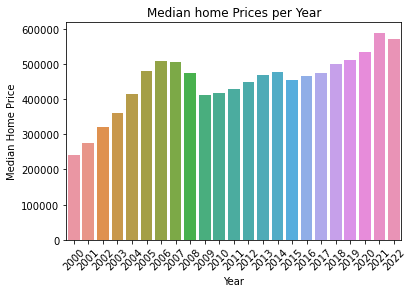

In [182]:
sns.barplot(x = median_home_prices.index, y =median_home_prices.values)
plt.title("Median home Prices per Year")
plt.xlabel('Year')
plt.ylabel('Median Home Price')
plt.xticks(rotation=45)
plt.show()

In [183]:
sdat_unfinished_permit = sdat_with_permits.loc[(sdat_with_permits.sales_date > sdat_with_permits.issueddate) & 
                      (sdat_with_permits.finaleddate.isnull()) & (sdat_with_permits.sales_price >0)]

sdat_with_finished_permit = sdat_with_permits.loc[(sdat_with_permits.finaleddate.notnull()) & (sdat_with_permits.sales_price >0)]

sem_unfinished = sdat_unfinished_permit.sales_price.std() / np.sqrt(len(sdat_unfinished_permit.sales_price))
sem_finished = sdat_with_finished_permit.sales_price.std() / np.sqrt(len(sdat_with_finished_permit.sales_price))

sem_diff = np.sqrt(sem_unfinished**2 + sem_finished**2)

mean_diff = sdat_with_finished_permit.sales_price.mean() - sdat_unfinished_permit.sales_price.mean()
lcb = mean_diff - 1.96*sem_diff
ucb = mean_diff + 1.96*sem_diff
(lcb, ucb)

(-215012.49808659364, -161689.86402114452)

In [184]:
print(sm.stats.ttest_ind(sdat_with_finished_permit.sales_price,
                         sdat_unfinished_permit.sales_price))

(-16.575936884501232, 3.0887696947343756e-61, 17286.0)


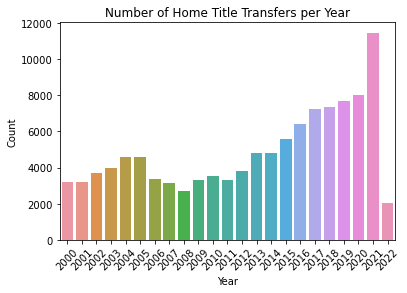

In [185]:
#houses transfer
k = sdat_res.year.loc[sdat_res.sales_price >0].value_counts()
sns.barplot(x = k.index, y =k.values)
plt.title("Number of Home Title Transfers per Year")
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

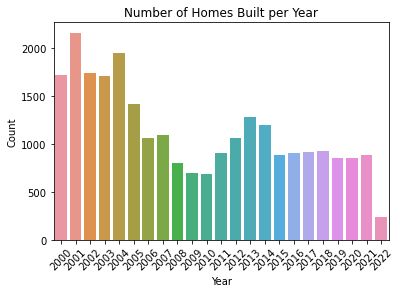

In [187]:
#number of houses bult
k = complete_construction_permits.loc[complete_construction_permits['year'] != 0].year.value_counts()
sns.barplot(x = k.index, y =k.values)
plt.title("Number of Homes Built per Year")
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

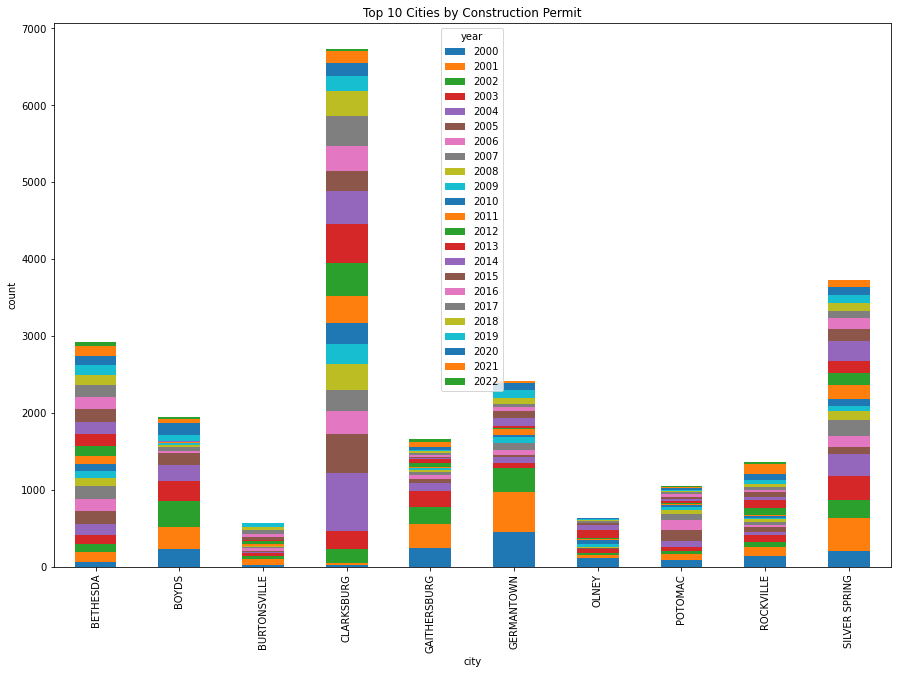

In [188]:
#extract top 10 zipcode by permit count
t = complete_construction_permits[complete_construction_permits['issueddate'].notnull()].groupby(['city'])['city'].agg('count')
t = t.sort_values(ascending=False)
top = list(t.index[:10])

date = complete_construction_permits.loc[(complete_construction_permits['city'].isin(top)) &
                                 (complete_construction_permits['year'] != 0)].groupby(['city'])['year'].value_counts()
date = date.unstack()

date.plot(kind='bar', stacked=True, figsize=(15,10), title='Top 10 Cities by Construction Permit',
                  ylabel = 'count')
plt.show()

In [189]:
complete_construction_permits.replace(2081.0, 20816, inplace = True)
date2 = complete_construction_permits.loc[(complete_construction_permits['city'].isin(top)) &
                                         (complete_construction_permits['zip'] != 0)].groupby(['city'])['zip'].value_counts()
date2

city           zip  
BETHESDA       20817    1597
               20814     997
               20816     414
               20852       4
               20815       1
BOYDS          20841    1968
               20874       1
BURTONSVILLE   20866     572
CLARKSBURG     20871    6769
               20841       5
GAITHERSBURG   20882     718
               20878     563
               20879     293
               20877     110
GERMANTOWN     20874    1940
               20876     522
OLNEY          20832     638
POTOMAC        20854    1072
ROCKVILLE      20850     484
               20855     416
               20852     259
               20853     195
               20851      27
               20854       7
SILVER SPRING  20906    1387
               20904     894
               20902     603
               20905     437
               20910     366
               20901     126
               20903      23
Name: zip, dtype: int64

In [203]:
#Frequency table to show types of homes built in top 10 cities
t = complete_construction_permits[(complete_construction_permits['finaleddate'].notnull()) &
                                (complete_construction_permits['city'].isin(top))].groupby(['city'])['usecode'].value_counts()
t = t.unstack()
t = t.apply(lambda x: x/x.sum() ,axis = 1)
t

usecode,DUPLEX,MODULAR,MULTI-FAMILY DWELLING,MULTI-FAMILY SENIOR CITIZEN BL,MULTIFAMILY DWELLING HIGH RISE,MULTIFAMILY DWELLING LOW RISE,SENIOR TOWNHOUSE,SENIOR VILLAS,SINGLE FAMILY DWELLING,TOWNHOUSE
city,,,,,,,,,,
BETHESDA,NaN,0.009287,0.021227,0.000663,0.006302,0.002322,NaN,NaN,0.921725,0.038474
BOYDS,0.003555,0.003047,0.001016,NaN,NaN,NaN,NaN,NaN,0.827324,0.165058
BURTONSVILLE,NaN,0.003497,0.041958,NaN,NaN,NaN,NaN,NaN,0.692308,0.262238
CLARKSBURG,0.001181,0.000738,0.131385,0.000148,0.000148,0.022882,0.001771,0.001033,0.445084,0.395630
GAITHERSBURG,0.001188,0.015439,0.003563,0.023159,NaN,0.001188,NaN,NaN,0.833729,0.121734
GERMANTOWN,NaN,0.001219,0.183997,0.001625,0.001625,0.019496,NaN,NaN,0.374086,0.417953
OLNEY,0.010972,NaN,0.056426,0.003135,NaN,NaN,NaN,NaN,0.695925,0.233542
POTOMAC,NaN,0.004664,0.138993,0.000933,0.000933,0.000933,NaN,NaN,0.825560,0.027985
ROCKVILLE,NaN,0.004320,0.066955,0.004320,0.002160,0.071274,NaN,NaN,0.550756,0.300216


# Word Cloud

In [29]:
desc = []
for i,row in filtered_Res_permits_df.iterrows():
    if row.worktype != 'CONSTRUCT':
        desc.append(str(row.description))
description = '.'.join(desc)

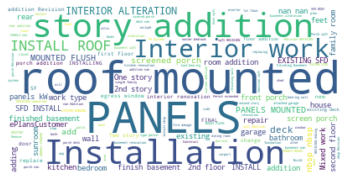

In [30]:
update_words=['ePlans', 'Customer', 'Use', 'Want', 'Wants', "Square", "Foot", 'SQ', "FT"]
STOPWORDS.update(update_words)
cloud_east_of_eden = WordCloud(background_color="white", stopwords=STOPWORDS).generate(description)
# Create a figure of the generated cloud
plt.imshow(cloud_east_of_eden, interpolation='bilinear')  
plt.axis('off')
# Display the figure
plt.show()

# Word Cloud for Unfinished Permits

In [20]:
diff = []
for i,row in filtered_Res_permits_df.iterrows():
    if row.worktype != 'CONSTRUCT':
        value = row.finaleddate - row.issueddate
        diff.append(value.days)

        
import numpy as np
from numpy import nan
my_array = np.array(diff)
new_array = my_array[np.logical_not(np.isnan(my_array))]

In [297]:
np.mean(new_array)

197.6634130470148

In [310]:
np.std(new_array)

328.281371996446

In [313]:
np.median(new_array)

118.0

In [53]:
import datetime
dt_string = "2021-9-28 0:00:00" 
format = "%Y-%m-%d %H:%M:%S"
dt_object = datetime.datetime.strptime(dt_string, format)

before = filtered_Res_permits_df.loc[(filtered_Res_permits_df.issueddate<dt_object) & 
                                     (filtered_Res_permits_df.finaleddate.isnull()) &
                                    (filtered_Res_permits_df.issueddate.notnull())]

In [33]:
unfinished = []
for i,row in before.iterrows():
    if row.worktype != 'CONSTRUCT':
        unfinished.append(str(row.description))
unfinished_description = '.'.join(desc)

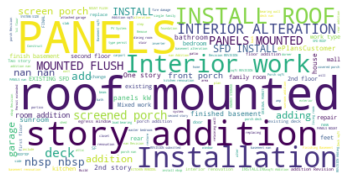

In [34]:
update_words=['ePlans', 'Customer', 'Use', 'Want', 'Wants', "Square", "Foot", 'SQ', "FT"]
STOPWORDS.update(update_words)
cloud_east_of_eden = WordCloud(background_color="white", stopwords=STOPWORDS).generate(unfinished_description)
# Create a figure of the generated cloud
plt.imshow(cloud_east_of_eden, interpolation='bilinear')  
plt.axis('off')
# Display the figure
plt.show()

# map

In [205]:
#create a list of latitude and longitude for heat map
heat_data = [[row['latitude'],row['longitude']] for index, row in heatmap_coords.iterrows()]

In [206]:
#create map

#starting location to center map
m = folium.Map(location=[39.215523,-77.18297])

#create markers for map
for i,row in zillow_with_permits.iterrows():
    if row.propertyType == 'SINGLE_FAMILY':
        folium.CircleMarker((row.latitude_x,row.longitude_x), radius=5,
                            weight=2, color='blue', 
                            fill_color='white', 
                            fill_opacity=.5,
                            tooltip= row.propertyType,
                            popup=f"""<i>
                            Zpid: {row.zpid}
                            Price: {row.price},
                            Permit work: {row.worktype},
                            Description of Work:{row.description},
                            Issue Date: {row.issueddate},
                            final date: {row.finaleddate}
                            </i>""").add_to(m)
    elif row.propertyType == 'TOWNHOUSE':
        folium.CircleMarker((row.latitude_x,row.longitude_x), radius=5,
                            weight=2, color='green', 
                            fill_color='white', 
                            fill_opacity=.5,
                            tooltip= row.propertyType,
                            popup=f"""<i>
                            Zpid: {row.zpid}
                            Price: {row.price},
                            Permit work: {row.worktype},
                            Description of Work:{row.description},
                            Issue Date: {row.issueddate},
                            final date: {row.finaleddate}
                            </i>""").add_to(m)
    elif row.propertyType == 'CONDO':
        folium.CircleMarker((row.latitude_x,row.longitude_x), radius=5,
                            weight=2, color='black', 
                            fill_color='white', 
                            fill_opacity=.5,
                            tooltip= row.propertyType,
                            popup=f"""<i>
                            Zpid: {row.zpid},
                            Price: {row.price},
                            Permit work: {row.worktype},
                            Description of Work:{row.description},
                            Issue Date: {row.issueddate},
                            final date: {row.finaleddate}
                            </i>""").add_to(m)

               
#plot heat map
HeatMap(heat_data, min_opacity=0.1).add_to(folium.FeatureGroup(name='Heat Map').add_to(m))
folium.LayerControl().add_to(m)

#show map
display(m)

# Reference

https://stackoverflow.com/questions/22245171/how-to-lowercase-a-pandas-dataframe-string-column-if-it-has-missing-values

https://stackoverflow.com/questions/9744775/how-to-convert-integer-timestamp-to-python-datetime

https://towardsdatascience.com/making-3-easy-maps-with-python-fb7dfb1036

https://www.kaggle.com/code/daveianhickey/how-to-folium-for-maps-heatmaps-time-data/notebook#Heatmaps,-boo-ya!